# Predicting type of urban crime

## Python, Kaggle, and SF OpenData

---

Hana Lee

14 January 2016

ChiPy Monthly Meeting

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context(context="talk")

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sfcrimes = pd.read_csv("train.csv")
sfcrimes["Category"] = sfcrimes["Category"].astype("category")

from sklearn.preprocessing import LabelEncoder
cat_codes = LabelEncoder()
cat_codes.fit(sfcrimes["Category"].cat.categories)

sfcrimes["CatCodes"] = cat_codes.transform(sfcrimes["Category"])

## Looking at the data

In [70]:
sfcrimes.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CatCodes
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,37
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,21
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,21
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,16
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,16


* Not many variables
* Test data set does not have Description or Resolution

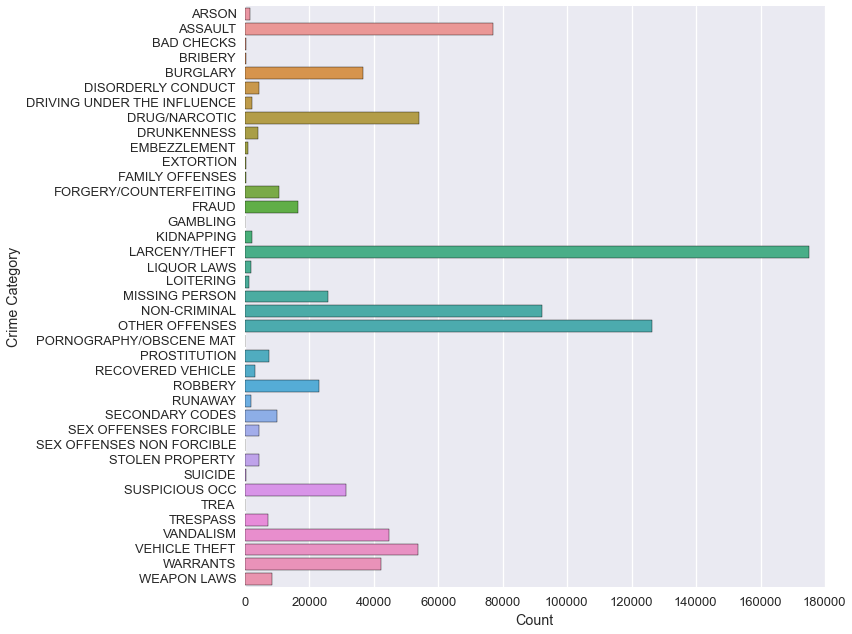

In [39]:
plt.figure(figsize = (8*1.3, 8*1.3))
sns.countplot(y = "Category", data = sfcrimes)
sns.axlabel("Count", "Crime Category")

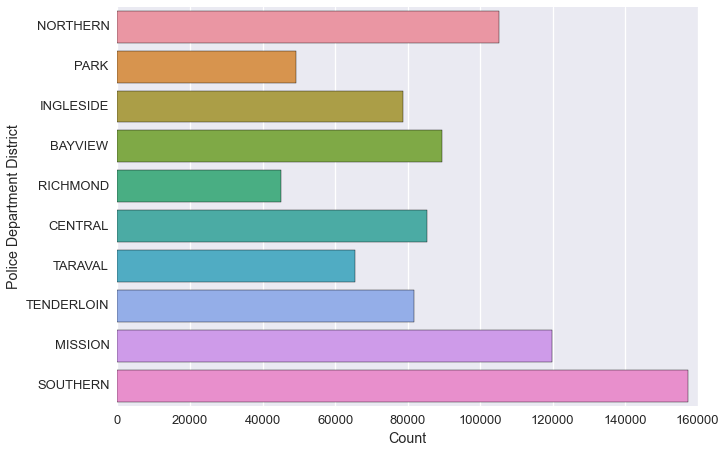

In [20]:
sns.countplot(y="PdDistrict", data=sfcrimes)
sns.axlabel("Count", "Police Department District")

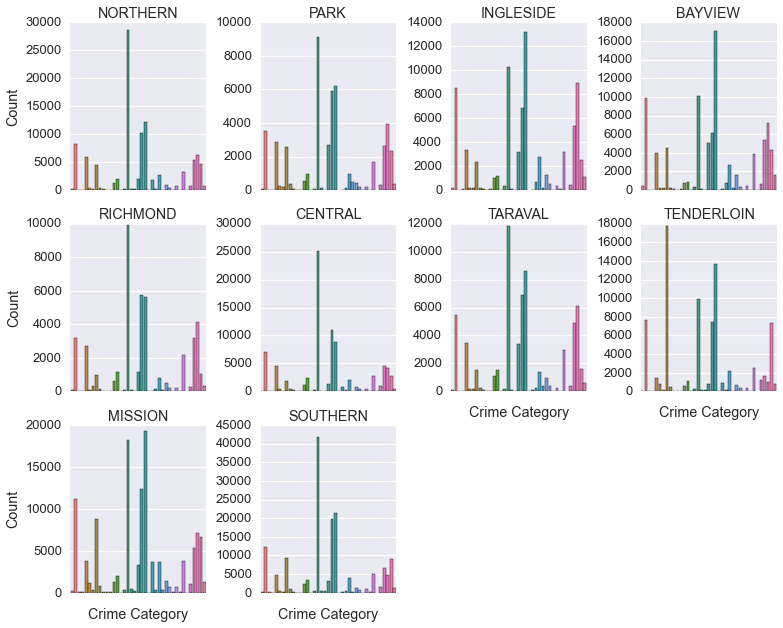

In [65]:
g = sns.FacetGrid(col = "PdDistrict", data = sfcrimes, col_wrap = 4, sharey = False)
(g.map(sns.countplot, "Category", palette = "husl")
  .set_axis_labels("Crime Category", "Count")
  .set_xticklabels([])
  .set_titles("{col_name}")
  .fig.subplots_adjust(hspace = 0.2, wspace = 0.4))

## A preliminary model

* Let's just look at police district for now
* Logistic regression to build a classifier
* Log-loss metric on 5-fold cross-validation to evaluate model performance

In [4]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

kf = StratifiedKFold(sfcrimes["CatCodes"], 
                     n_folds=5, 
                     shuffle=True, 
                     random_state=333)

def log_loss_kfold(alg, train_features, train_target,
                   test_features, test_target):
    train_fit = alg.fit(train_features, train_target)
    test_pred = train_fit.predict_proba(test_features)
    return log_loss(test_target, test_pred)

In [86]:
features = pd.get_dummies(sfcrimes["PdDistrict"], 
                          prefix="Pd")
features.head(5)

,Pd_BAYVIEW,Pd_CENTRAL,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [16]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

scores = [log_loss_kfold(logr,
                         features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

## How did it do against the test set?

* Log-loss score = 2.61626
* Top score = 2.06702
* Police district by itself still does surprisingly well

## Improving the model

### Higher-resolution geographical data

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


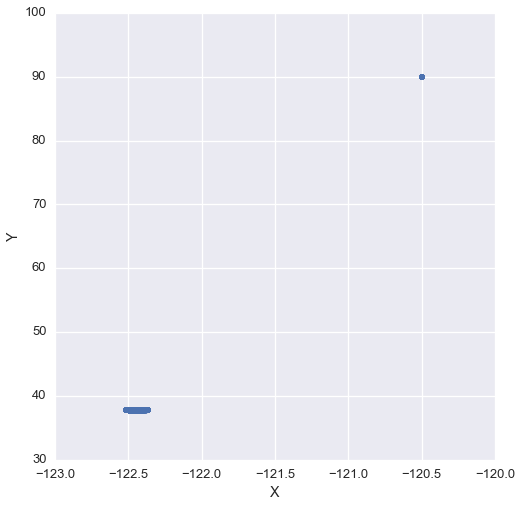

In [93]:
g = sns.PairGrid(data = sfcrimes,
                 x_vars = ['X'],
                 y_vars = ['Y'],
                 size = 5.5*1.3)
g = g.map(plt.scatter)

In [12]:
pd_districts = sfcrimes.groupby("PdDistrict")
pd_means = pd_districts.agg({'X': np.mean,
                             'Y': np.mean})

outliers = (sfcrimes['X'] > -122) | (sfcrimes['Y'] > 38)
imputed_values = pd.DataFrame({idx: pd_means.loc[row['PdDistrict']]
                               for idx, row in sfcrimes[outliers].iterrows()})
sfcrimes.loc[outliers, ('X', 'Y')] = imputed_values.transpose()

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


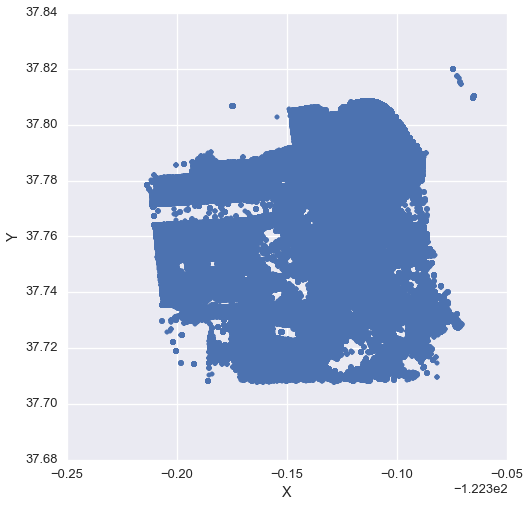

In [97]:
g = sns.PairGrid(data = sfcrimes,
                 x_vars = ['X'],
                 y_vars = ['Y'],
                 size = 5.5*1.3)
g = g.map(plt.scatter)

In [13]:
from sklearn.cluster import KMeans

k150 = KMeans(n_clusters = 150,
              max_iter = 100,
              random_state = 333).fit(sfcrimes[['X', 'Y']])
sfcrimes["Neighborhood"] = k150.predict(sfcrimes[['X', 'Y']])

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


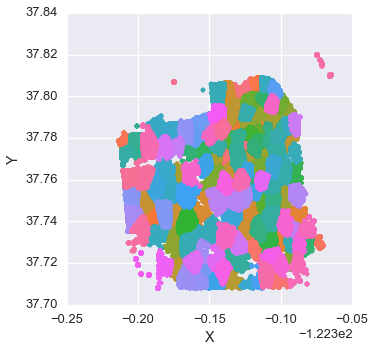

In [105]:
g = sns.PairGrid(data = sfcrimes,
                 hue = "Neighborhood",
                 palette = "husl",
                 x_vars = ['X'],
                 y_vars = ['Y'],
                 size = 5)
g = g.map(plt.scatter)

## Improving the model

### Date and time data

In [7]:
timestamps = pd.to_datetime(sfcrimes["Dates"])
timestamps.index = pd.DatetimeIndex(timestamps)

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


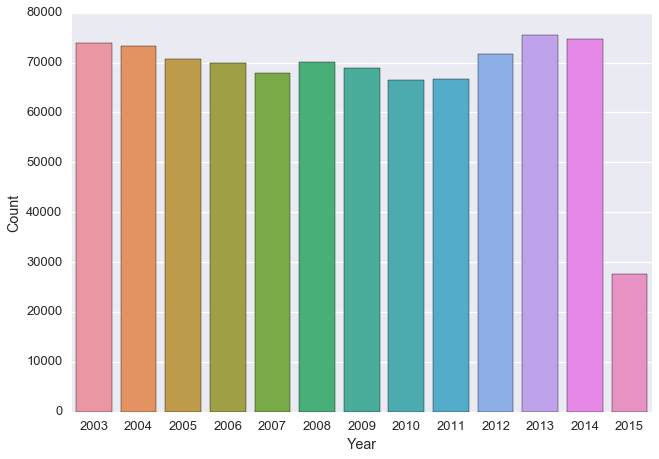

In [8]:
sfcrimes["Year"] = timestamps.index.year

sns.countplot(x = "Year",
              data = sfcrimes,
              order = range(2003, 2016))
sns.axlabel("Year", "Count")

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


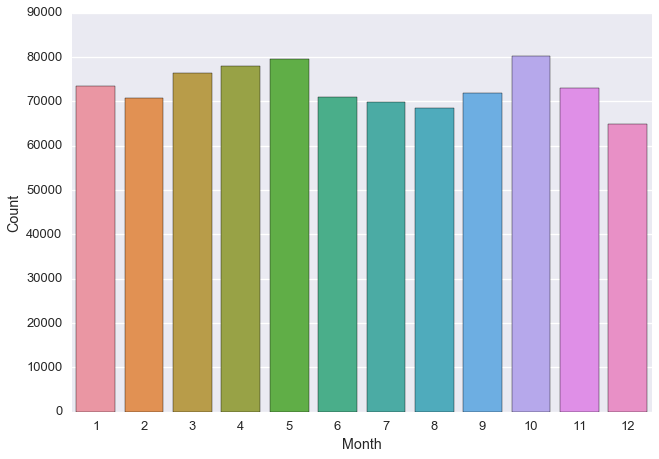

In [9]:
sfcrimes["Month"] = timestamps.index.month

sns.countplot(x = "Month",
              data = sfcrimes,
              order = range(1, 13))
sns.axlabel("Month", "Count")

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


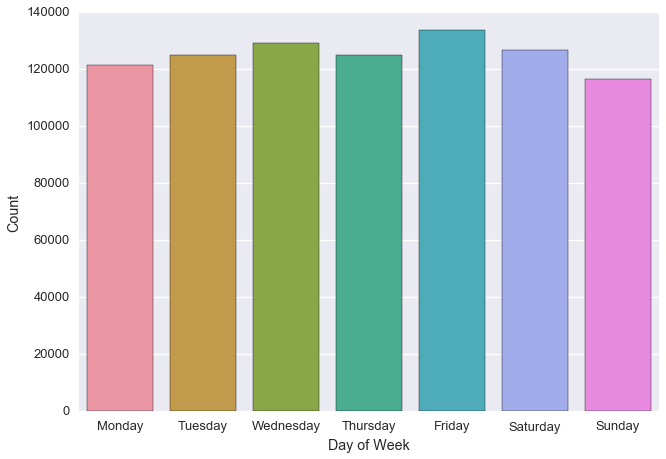

In [10]:
DAYS = ["Mon", "Tues", "Wednes", "Thurs", "Fri", "Satur", "Sun"]

sns.countplot(x = "DayOfWeek",
              data = sfcrimes,
              order = [x + "day" for x in DAYS])
sns.axlabel("Day of Week", "Count")

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


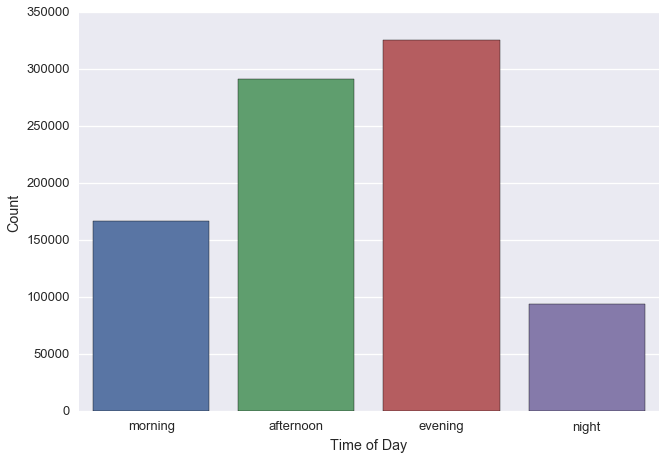

In [11]:
def time_of_day(hour):
    if hour >= 1 and hour < 7:
        return "night"
    elif hour >=7 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "afternoon"
    else:
        return "evening"

sfcrimes["TimeOfDay"] = pd.Series([time_of_day(hour) 
                                   for hour in timestamps.index.hour])
sns.countplot(x = "TimeOfDay",
              data = sfcrimes,
              order = ["morning", "afternoon", "evening", "night"])
sns.axlabel("Time of Day", "Count")

## A more complicated model

* Adding higher-resolution geographical and datetime data
* Treating as categorical variables
* Logistic regression to fit the training set data

In [14]:
features = pd.concat([pd.get_dummies(sfcrimes["Year"],
                                     prefix = "Y"),
                      pd.get_dummies(sfcrimes["Month"],
                                     prefix = "M"),
                      pd.get_dummies(sfcrimes["DayOfWeek"]),
                      pd.get_dummies(sfcrimes["TimeOfDay"]),
                      pd.get_dummies(sfcrimes["PdDistrict"],
                                     prefix = "Pd"),
                      pd.get_dummies(sfcrimes["Neighborhood"],
                                     prefix = "N")],
                     axis = 1)
features.head(5)

,Y_2003,Y_2004,Y_2005,Y_2006,Y_2007,Y_2008,Y_2009,Y_2010,Y_2011,Y_2012,...,N_140,N_141,N_142,N_143,N_144,N_145,N_146,N_147,N_148,N_149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scores = [log_loss_kfold(logr,
                         features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

## How did it do against the test set?

* Score = 2.54026
* Top score = 2.05079
* Moved up 306 positions on the leaderboard

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10,
                            min_samples_leaf = 5,
                            max_depth = 40,
                            random_state = 333)

rf_model = rf.fit(features, sfcrimes["CatCodes"])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators = 10,
                            min_samples_leaf = 5,
                            max_depth = 40,
                            random_state = 333,
                            n_jobs = 2)

gb = GradientBoostingClassifier(n_estimators = 10,
                                min_samples_leaf = 5, 
                                max_depth = 40, 
                                random_state = 333,
                                n_jobs = 2)

lr_fit, rf_fit, gb_fit = [[alg.fit(features.iloc[train_idx],
                                   sfcrimes["CatCodes"].iloc[train_idx]) 
                           for train_idx, test_idx in kf] for alg in [lr, rf, gb]]

In [109]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10,
                            min_samples_leaf = 5,
                            max_depth = 40,
                            random_state = 333)

In [ ]:
scores = [log_loss_kfold(rf,
                         features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

In [177]:
model = rf.fit(features, sfcrimes["CatCodes"])

In [145]:
importance = pd.DataFrame({"Features": features.columns,
                           "Importances": model.feature_importances_})
importance = importance.sort_values("Importances", ascending = False)

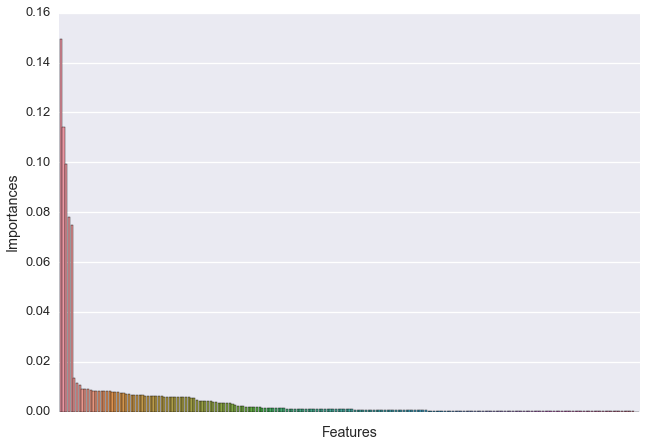

In [158]:
g = sns.barplot(data = importance, x = "Features", y = "Importances")
g.set_xticklabels([])
sns.axlabel("Features", "Importances")

In [159]:
importance[importance["Importances"] > 0.02]

,Features,Importances
47,R_NONE,0.149303
37,"R_ARREST, CITED",0.114210
36,"R_ARREST, BOOKED",0.099314
46,R_LOCATED,0.078270
51,R_PSYCHOPATHIC CASE,0.074698


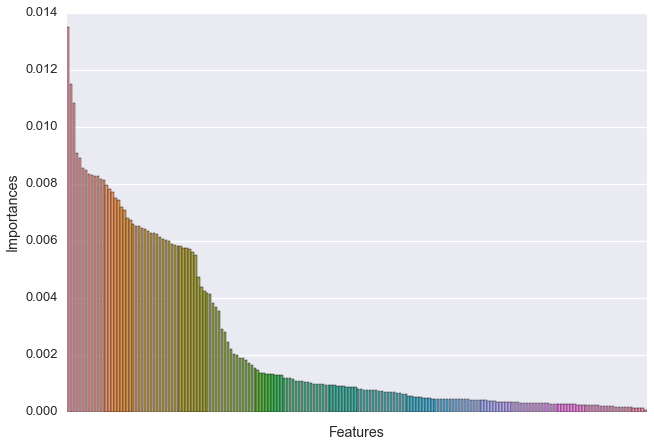

In [171]:
filter = importance["Features"].map(lambda x: str(x).startswith("R_"))
g = sns.barplot(data = importance[-filter], 
                x = "Features", 
                y = "Importances")
g.set_xticklabels([])
sns.axlabel("Features", "Importances")

In [175]:
importance[-filter & (importance["Importances"] > 0.005)]

,Features,Importances
62,Pd_TENDERLOIN,0.013511
190,N_127,0.011512
33,evening,0.010839
60,Pd_SOUTHERN,0.009082
32,afternoon,0.008918
27,Saturday,0.008535
25,Friday,0.008468
31,Wednesday,0.008349
29,Thursday,0.008296
26,Monday,0.008282
